<a href="https://colab.research.google.com/github/AlbertoMartinezS/idal_ia3/blob/main/EJERCICIO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**El objetivo del ejercicio es:**

- Optimizar arquitectura de la red

- Partir training en training + validación usando como ejemplo lo que se hacía en el notebook de las caras (carpeta 03-caras)

- Sacar heatmaps

In [11]:
COLAB = True

In [13]:
if COLAB:
    %tensorflow_version 1.x
    !pip install h5py==2.10.0

TensorFlow is already loaded. Please restart the runtime to change versions.


Si se desea ejecutar en local:

- Descargar el dataset de training de: https://drive.google.com/file/d/1ChJn1h340ECm1uezE-oLr6TwCbeGglvQ

- Y el de test de: https://drive.google.com/file/d/1STokCqelhLeiwlTa2YX-TM9SNCx74-an

- Poner variable COLAB a False

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [4]:
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Dec  3 14:33 .
drwxr-xr-x 1 root root 4096 Dec 11 10:00 ..
drwxr-xr-x 4 root root 4096 Dec  3 14:33 .config
drwxr-xr-x 1 root root 4096 Dec  3 14:33 sample_data


In [12]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1ChJn1h340ECm1uezE-oLr6TwCbeGglvQ',
                                        dest_path='./seg_train.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1STokCqelhLeiwlTa2YX-TM9SNCx74-an',
                                        dest_path='./seg_test.zip', unzip=True)
    

Unzipping...Done.
Unzipping...Done.


In [94]:
!ls -la

total 255244
drwxr-xr-x 1 root root      4096 Dec 11 10:19 .
drwxr-xr-x 1 root root      4096 Dec 11 10:00 ..
-rw-r--r-- 1 root root   1608384 Dec 11 10:33 best_model.h5
drwxr-xr-x 4 root root      4096 Dec  3 14:33 .config
drwxr-xr-x 4 root root      4096 Dec 11 10:05 __MACOSX
drwxr-xr-x 1 root root      4096 Dec  3 14:33 sample_data
drwxr-xr-x 8 root root      4096 Dec 11 10:05 seg_test
-rw-r--r-- 1 root root  45638665 Dec 11 10:05 seg_test.zip
drwxr-xr-x 8 root root      4096 Dec 11 10:05 seg_train
-rw-r--r-- 1 root root 214084517 Dec 11 10:05 seg_train.zip


In [95]:
!ls seg_train

buildings  forest  glacier  mountain  sea  street


In [96]:
!ls seg_test

buildings  forest  glacier  mountain  sea  street


In [97]:
!ls seg_train/buildings

0.jpg	   12578.jpg  14916.jpg  17468.jpg  20017.jpg  4600.jpg  7382.jpg
10006.jpg  12590.jpg  14918.jpg  17479.jpg  20027.jpg  4620.jpg  7383.jpg
10014.jpg  125.jpg    14947.jpg  17480.jpg  2002.jpg   4621.jpg  739.jpg
10018.jpg  12602.jpg  14952.jpg  17491.jpg  20048.jpg  4623.jpg  7418.jpg
1001.jpg   12615.jpg  14958.jpg  17495.jpg  20054.jpg  4630.jpg  742.jpg
10029.jpg  12617.jpg  14968.jpg  17503.jpg  2038.jpg   4631.jpg  7439.jpg
10032.jpg  12629.jpg  14984.jpg  17516.jpg  2041.jpg   4634.jpg  7443.jpg
10056.jpg  12632.jpg  14991.jpg  1751.jpg   2043.jpg   463.jpg	 7455.jpg
1009.jpg   12636.jpg  1501.jpg	 17520.jpg  2059.jpg   4667.jpg  7463.jpg
10113.jpg  1263.jpg   15026.jpg  17537.jpg  2069.jpg   4686.jpg  7471.jpg
10126.jpg  12649.jpg  15030.jpg  17539.jpg  2076.jpg   4715.jpg  7478.jpg
1012.jpg   12659.jpg  1503.jpg	 1753.jpg   2083.jpg   4748.jpg  747.jpg
10144.jpg  12668.jpg  15042.jpg  17541.jpg  2088.jpg   4770.jpg  7491.jpg
10151.jpg  12669.jpg  15045.jpg  17545.jpg  20

In [98]:
ficheros = glob("./seg_train/forest/*")
ficheros[0]

'./seg_train/forest/1844.jpg'

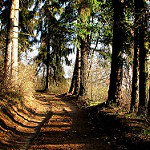

In [15]:
imagen = load_img(ficheros[4])
imagen

In [16]:
imagen.size

(150, 150)

In [ ]:
#partir training en training y validacion

In [103]:
clases= ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

rutas_trval= []
clases_trval= []


for clase in clases:
  rutas_aux = glob("./seg_train/forest/*".format(clase))
  clases_aux = len(rutas_aux)*[clase]
  print(rutas_aux[:3])
  print(clases_aux[:3])


  rutas_trval.extend(rutas_aux)
  clases_trval.extend(clases_aux)

['./seg_train/forest/1844.jpg', './seg_train/forest/11724.jpg', './seg_train/forest/2699.jpg']
['buildings', 'buildings', 'buildings']
['./seg_train/forest/1844.jpg', './seg_train/forest/11724.jpg', './seg_train/forest/2699.jpg']
['forest', 'forest', 'forest']
['./seg_train/forest/1844.jpg', './seg_train/forest/11724.jpg', './seg_train/forest/2699.jpg']
['glacier', 'glacier', 'glacier']
['./seg_train/forest/1844.jpg', './seg_train/forest/11724.jpg', './seg_train/forest/2699.jpg']
['mountain', 'mountain', 'mountain']
['./seg_train/forest/1844.jpg', './seg_train/forest/11724.jpg', './seg_train/forest/2699.jpg']
['sea', 'sea', 'sea']
['./seg_train/forest/1844.jpg', './seg_train/forest/11724.jpg', './seg_train/forest/2699.jpg']
['street', 'street', 'street']


In [110]:
import pandas as pd


df_trval= pd.DataFrame({'ruta':rutas_trval, 'clase':clases_trval})
df_trval

,ruta,clase
0,./seg_train/forest/1844.jpg,buildings
1,./seg_train/forest/11724.jpg,buildings
2,./seg_train/forest/2699.jpg,buildings
3,./seg_train/forest/12016.jpg,buildings
4,./seg_train/forest/13880.jpg,buildings
...,...,...
13621,./seg_train/forest/7955.jpg,street
13622,./seg_train/forest/1096.jpg,street
13623,./seg_train/forest/19072.jpg,street
13624,./seg_train/forest/2457.jpg,street


In [111]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_trval, train_size= 0.5, random_state=1, stratify=df_trval["clase"])

In [112]:
df_train['clase'].value_counts() / len(df_train)*100

forest       16.674006
glacier      16.674006
sea          16.674006
buildings    16.659328
mountain     16.659328
street       16.659328
Name: clase, dtype: float64

In [113]:
df_val['clase'].value_counts() / len(df_train)*100

buildings    16.674006
mountain     16.674006
street       16.674006
forest       16.659328
glacier      16.659328
sea          16.659328
Name: clase, dtype: float64

In [114]:
#train_data_dir = 'seg_train'
#validation_data_dir = 'seg_test'
test_data_dir = 'seg_test'

batch_size = 16

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [115]:

# data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='mirror', # 'nearest',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

In [116]:
imagen_num = np.array([img_to_array(imagen)])

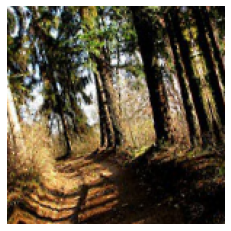

In [117]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

In [118]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 75, 75

normed_dims = (img_height, img_width)

In [119]:
normed_dims

(75, 75)

In [79]:
# sparse_categorical_crossentropy

#building: 0
# 1,0,0,0,0,0

# forest': 1
# 0,1,0,0,0,0

# glacier: 2
# 0,0,1,0,0,0

# mountain: 3
# 0,0,0,1,0,0

# sea: 4,
# 0,0,0,0,1,0

# street: 5
# 0,0,0,0,0,1

In [120]:
# Definir arquitectura del modelo:

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu',
                 input_shape=normed_dims+(3,)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
# aqui empieza la red neuronal 'standard'
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu', kernel_regularizer="l2")) # regularizador L2
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))




model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [81]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 17, 17, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 7, 7, 64)        

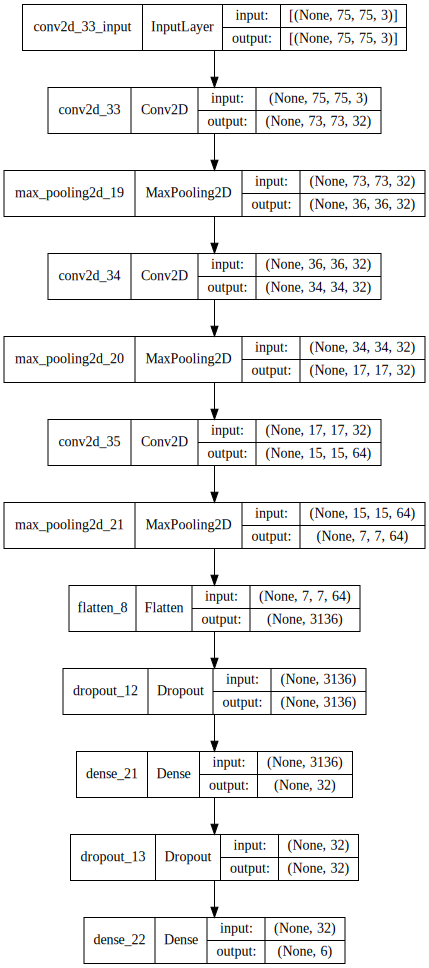

In [121]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [122]:
def preprocess_input(x):
    return x/255

In [123]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [124]:
validation_data_dir, normed_dims

('seg_test', (75, 75))

In [125]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [126]:
test_datagen.flow_from_dataframe

<bound method ImageDataGenerator.flow_from_dataframe of <keras.preprocessing.image.ImageDataGenerator object at 0x7fe35fcbf310>>

In [127]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [128]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(14034, 3000, 3000)

In [129]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [130]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


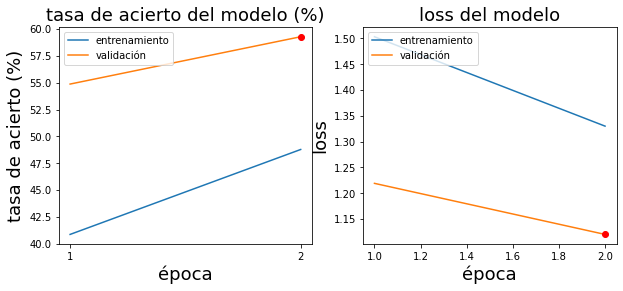

  1/877 [..............................] - ETA: 53s - loss: 1.6512 - accuracy: 0.3750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


675/877 [======================>.......] - ETA: 9s - loss: 1.2806 - accuracy: 0.5167 

In [ ]:
epochs = 50

modelpath="best_model.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
!ls -la

In [ ]:
model = load_model(modelpath)

## **Resultados obtenidos**

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

In [ ]:
y_real = test_generator.classes
y_pred_proba = model.predict_generator(test_generator)

In [ ]:
y_real[:5]

In [ ]:
y_pred_proba[:5]

In [ ]:
test_generator.class_indices

In [ ]:
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

In [ ]:
for clase in range(6):
    nombre_clase = num2class[clase]

    fpr, tpr, thresholds = roc_curve(y_real==clase, y_pred_proba[:,clase])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.set_title(nombre_clase)
    ax1.legend()
    plt.show()

## **Visualización de ejemplos de test**

In [ ]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='sparse')

In [ ]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [ ]:
test_generator2.class_indices

In [ ]:
y_te

In [ ]:
ind_te1 = 145

image = X_te[ind_te1].copy()

print("Clase real:", num2class[y_te[ind_te1]])
plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0]
cadena = ""
for i in range(len(num2class)):
    cadena = cadena + "{}: {}% ".format(num2class[i], int(100*p[i]))
print(cadena)

In [ ]:
!ls

In [ ]:
# Para descargar el modelo a local:

#from google.colab import files
#files.download('./best_model.h5')